
# Mastodon.social — Top‑10 Accounts Analyzer (Notebook Skeleton)

This notebook targets **mastodon.social** using public endpoints to:
1) Discover the **top 10 local accounts by follower count** (Directory API).
2) Fetch each account’s **recent statuses** in a selectable timeframe (1h / 1d / 1w / 1m / 1y).
3) Compute **posting‑habit metrics** and **correlations** (including hour-of-day cosine similarity) and contrast them with a notable influencer.
4) Fetch **7‑day trending hashtags** and render a **word cloud**.

> Notes
> - Endpoints are public; an **access token** (optional) may improve rate limits.
> - The “Trending Tags” endpoint is **7‑day by design**; we use it as-is.
> - Time‑windowed post analysis paginates Account Statuses by `max_id` until the window is covered.



## API Cheat Sheet (mastodon.social)

Base: `https://mastodon.social`

- **Directory (discover top local users):**  
  `GET /api/v1/directory?local=true&order=active&limit=80&offset=…`
- **Lookup Account by handle:**  
  `GET /api/v1/accounts/lookup?acct=<user or user@domain>`
- **Get Account (by ID):**  
  `GET /api/v1/accounts/:id`
- **Get Account’s statuses (time‑window via pagination):**  
  `GET /api/v1/accounts/:id/statuses?limit=40&exclude_replies=false&exclude_reblogs=false&max_id=…`
- **Trending Tags (7‑day):**  
  `GET /api/v1/trends/tags?limit=20`


In [1]:

# Optional: install requirements (uncomment if needed)
# %pip install -q requests pandas numpy wordcloud matplotlib python-dateutil rich tqdm


In [2]:

import os, time, math, json
import requests
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, timezone
from collections import Counter, defaultdict
from dateutil.relativedelta import relativedelta
from typing import List, Dict, Any, Optional

BASE = "https://mastodon.social"
SESSION = requests.Session()
SESSION.headers.update({"User-Agent": "MastoTop10Notebook/0.1 (+analysis)"})
# Optional token (improves rate limits on some instances)
ACCESS_TOKEN = os.getenv("MASTODON_TOKEN", "").strip()
if ACCESS_TOKEN:
    SESSION.headers.update({"Authorization": f"Bearer {ACCESS_TOKEN}"})

# Use generous but safe defaults; you can tune these
DIR_PAGE_LIMIT = 80           # max per docs
STATUS_PAGE_LIMIT = 40        # max per docs
MAX_DIR_PAGES = 200           # try to use "all available" without being abusive
PACE_SEC = 0.35               # gentle pacing between requests

TIMEFRAMES = {
    "1h": {"hours":1},
    "1d": {"days":1},
    "1w": {"weeks":1},
    "1m": {"months":1},
    "1y": {"years":1},
}

# Influencer to contrast against (default: Mastodon founder)
DEFAULT_INFLUENCER = "Gargron@mastodon.social"


In [3]:

def http_get(path: str, params: Optional[dict]=None) -> Any:
    url = path if path.startswith("http") else f"{BASE}{path}"
    for attempt in range(4):
        try:
            r = SESSION.get(url, params=params, timeout=30)
            if r.status_code == 429:
                # Backoff if rate-limited
                time.sleep(5 + attempt*3)
                continue
            r.raise_for_status()
            return r.json()
        except Exception as e:
            if attempt == 3:
                raise
            time.sleep(1 + attempt*1.5)
    return None


In [4]:

def directory_top_local(n_target=10, min_active_since: Optional[datetime]=None) -> pd.DataFrame:
    """Scan local directory pages and return top accounts by followers_count.
    If min_active_since is set (UTC datetime), keep only accounts with last_status_at >= threshold.
    """
    records = []
    for page in range(MAX_DIR_PAGES):
        params = dict(local="true", order="active", limit=DIR_PAGE_LIMIT, offset=page*DIR_PAGE_LIMIT)
        data = http_get("/api/v1/directory", params=params)
        if not data:
            break
        for acc in data:
            last = acc.get("last_status_at")
            if min_active_since and last:
                try:
                    if datetime.fromisoformat(last.replace("Z","+00:00")) < min_active_since:
                        continue
                except Exception:
                    pass
            records.append(acc)
        time.sleep(PACE_SEC)
        # heuristic early stop if we already have a large pool
        if len(records) >= n_target * 20 and page >= 5:
            break

    if not records:
        return pd.DataFrame()

    df = (pd.DataFrame(records)
          .assign(followers_count=lambda d: d["followers_count"].fillna(0))
          .sort_values("followers_count", ascending=False)
          .reset_index(drop=True))
    # normalize handle to user@mastodon.social if not fully qualified
    df["handle"] = df["acct"].apply(lambda a: a if "@" in a else f"{a}@mastodon.social")
    return df.head(n_target)


In [5]:

def lookup_account(acct: str) -> Dict[str, Any]:
    return http_get("/api/v1/accounts/lookup", params={"acct": acct})

def get_account(acc_id: str) -> Dict[str, Any]:
    return http_get(f"/api/v1/accounts/{acc_id}")

def fetch_statuses_timewindow(acc_id: str, start_utc: datetime, end_utc: datetime,
                              exclude_replies=False, exclude_reblogs=False) -> List[Dict[str, Any]]:
    out = []
    max_id = None
    while True:
        params = {
            "limit": STATUS_PAGE_LIMIT,
            "exclude_replies": str(bool(exclude_replies)).lower(),
            "exclude_reblogs": str(bool(exclude_reblogs)).lower()
        }
        if max_id:
            params["max_id"] = max_id
        batch = http_get(f"/api/v1/accounts/{acc_id}/statuses", params=params)
        if not batch:
            break
        # batch is reverse-chronological
        stop = False
        for s in batch:
            t = datetime.fromisoformat(s["created_at"].replace("Z","+00:00"))
            if t > end_utc:
                continue
            if t < start_utc:
                stop = True
                break
            out.append(s)
        max_id = batch[-1]["id"]
        time.sleep(PACE_SEC)
        if stop:
            break
    return out


In [6]:

def metrics_from_statuses(statuses: List[Dict[str, Any]]) -> Dict[str, Any]:
    if not statuses:
        return dict(n_posts=0, posts_per_day=0.0, median_interval_min=None,
                    originals_share=None, replies_share=None, boosts_share=None,
                    media_share=None, avg_favs=None, avg_boosts=None, avg_replies=None,
                    hour_hist={}, dow_hist={}, top_hashtags=[])
    times = [datetime.fromisoformat(s["created_at"].replace("Z","+00:00")) for s in statuses]
    times_sorted = sorted(times)
    span_days = max(1e-9, (times_sorted[-1]-times_sorted[0]).total_seconds()/86400) if len(times_sorted)>1 else 1.0
    posts_per_day = len(times_sorted)/span_days

    # intervals
    intervals = [(t2 - t1).total_seconds()/60 for t1,t2 in zip(times_sorted, times_sorted[1:])]
    median_interval = float(pd.Series(intervals).median()) if intervals else None

    n = len(statuses)
    originals = sum(1 for s in statuses if not s.get("reblog"))
    boosts    = sum(1 for s in statuses if s.get("reblog"))
    replies   = sum(1 for s in statuses if s.get("in_reply_to_id"))
    media     = sum(1 for s in statuses if s.get("media_attachments"))

    favs_avg    = pd.Series([s.get("favourites_count",0) for s in statuses]).mean() if n else None
    boosts_avg  = pd.Series([s.get("reblogs_count",0) for s in statuses]).mean() if n else None
    replies_avg = pd.Series([s.get("replies_count",0) for s in statuses]).mean() if n else None

    hour_hist = pd.Series([t.hour for t in times]).value_counts().sort_index().to_dict()
    dow_hist  = pd.Series([t.weekday() for t in times]).value_counts().sort_index().to_dict()

    tag_counter = Counter()
    for s in statuses:
        for tag in s.get("tags", []):
            name = tag.get("name")
            if name:
                tag_counter[name.lower()] += 1
    top_hashtags = tag_counter.most_common(100)

    return dict(
        n_posts=n,
        posts_per_day=round(posts_per_day,2),
        median_interval_min=(round(median_interval,1) if median_interval is not None else None),
        originals_share=round(originals/n,3) if n else None,
        replies_share=round(replies/n,3) if n else None,
        boosts_share=round(boosts/n,3) if n else None,
        media_share=round(media/n,3) if n else None,
        avg_favs=round(float(favs_avg),2) if favs_avg is not None else None,
        avg_boosts=round(float(boosts_avg),2) if boosts_avg is not None else None,
        avg_replies=round(float(replies_avg),2) if replies_avg is not None else None,
        hour_hist=hour_hist, dow_hist=dow_hist, top_hashtags=top_hashtags
    )


In [7]:

def hour_vec(hist: Dict[int,int]) -> np.ndarray:
    vec = np.zeros(24, dtype=float)
    for k,v in (hist or {}).items():
        k = int(k)
        if 0 <= k <= 23:
            vec[k] = v
    s = vec.sum()
    return vec/s if s else vec

def cosine(a: np.ndarray, b: np.ndarray) -> float:
    den = (np.linalg.norm(a)*np.linalg.norm(b))
    return float(a.dot(b)/den) if den else float("nan")

def correlate(metrics_df: pd.DataFrame) -> Dict[str, Any]:
    scalar_cols = ["posts_per_day","median_interval_min","originals_share","replies_share","boosts_share","media_share","avg_favs","avg_boosts","avg_replies"]
    spearman = metrics_df[scalar_cols].corr(method="spearman")
    # hour-of-day cosine
    hv = {h: hour_vec(hist) for h, hist in zip(metrics_df["handle"], metrics_df["hour_hist"])}
    handles = list(hv.keys())
    cos = pd.DataFrame(index=handles, columns=handles, dtype=float)
    for i in handles:
        for j in handles:
            cos.loc[i,j] = cosine(hv[i], hv[j])
    return {"spearman": spearman, "hour_cosine": cos}


In [8]:

def trending_tags_7d(limit=20) -> pd.DataFrame:
    data = http_get("/api/v1/trends/tags", params={"limit": limit}) or []
    rows = []
    for tag in data:
        name = tag.get("name","").lower()
        hist = tag.get("history", [])
        uses_7d = sum(int(h.get("uses",0)) for h in hist)
        accts_7d = sum(int(h.get("accounts",0)) for h in hist)
        rows.append({"hashtag":"#"+name, "uses_7d":uses_7d, "accounts_7d":accts_7d})
    df = pd.DataFrame(rows).sort_values(["uses_7d","accounts_7d"], ascending=False).reset_index(drop=True)
    return df

def pick_wide_unicode_font():
    import os, matplotlib.font_manager as fm
    for name in ["Noto Sans CJK JP","Noto Sans CJK KR","Noto Sans CJK SC","Noto Sans CJK TC",
                 "Noto Sans","Arial Unicode MS","Segoe UI Symbol","Apple Color Emoji","DejaVu Sans"]:
        try:
            p = fm.findfont(name, fallback_to_default=False)
            if os.path.isfile(p): return p
        except Exception:
            pass
    return fm.findfont("DejaVu Sans")

def render_wordcloud_from_counts(counts, width=1000, height=400):
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt
    font_path = pick_wide_unicode_font()
    wc = WordCloud(width=width, height=height, background_color="white",
                   font_path=font_path).generate_from_frequencies(counts)
    plt.figure(figsize=(width/100, height/100))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


In [9]:

# ---- USER CONTROLS ----
TIMEFRAME = "1w"  # one of: 1h, 1d, 1w, 1m, 1y
INFLUENCER = DEFAULT_INFLUENCER

# ---- COMPUTE WINDOW ----
now = datetime.now(timezone.utc)
delta = relativedelta(**TIMEFRAMES[TIMEFRAME])
start = now - delta

print(f"Time window: {start.isoformat()}  →  {now.isoformat()}   (UTC)")

# ---- DISCOVER TOP 10 ----
top10_df = directory_top_local(n_target=10, min_active_since=start)
if top10_df.empty:
    raise SystemExit("Directory returned no accounts. Try relaxing filters or check connectivity.")

print("Top 10 local by followers:")
display(top10_df[["handle","followers_count","last_status_at","statuses_count"]])

# Ensure influencer is included
handles = top10_df["handle"].tolist()
if INFLUENCER and INFLUENCER not in handles:
    handles.append(INFLUENCER)

# ---- FETCH & SUMMARIZE ----
rows = []
for h in handles:
    acc = lookup_account(h)
    acc_id = acc["id"]
    statuses = fetch_statuses_timewindow(acc_id, start, now)
    m = metrics_from_statuses(statuses)
    rows.append({
        "handle": acc["acct"] if "@" in acc["acct"] else f'{acc["acct"]}@mastodon.social',
        "followers": acc.get("followers_count"),
        **m
    })
    print(f"Fetched {len(statuses)} posts for {h}")

metrics_df = pd.DataFrame(rows)
display(metrics_df[["handle","followers","n_posts","posts_per_day","median_interval_min","avg_favs","avg_boosts","avg_replies","originals_share","replies_share","boosts_share","media_share"]])

# ---- CORRELATIONS ----
cors = correlate(metrics_df)
print("\nSpearman correlations:")
display(cors["spearman"])

print("\nPosting-window cosine similarities (hour-of-day):")
display(cors["hour_cosine"])


Time window: 2025-08-13T14:19:13.424847+00:00  →  2025-08-20T14:19:13.424847+00:00   (UTC)
Top 10 local by followers:


,handle,followers_count,last_status_at,statuses_count
0,derpostillon@mastodon.social,136832,2025-08-20,5190
1,nixCraft@mastodon.social,97801,2025-08-20,8742
2,tazgetroete@mastodon.social,75874,2025-08-20,23698
3,lemonde@mastodon.social,52205,2025-08-20,30941
4,Tutanota@mastodon.social,39303,2025-08-20,8319
5,paul_denton@mastodon.social,18502,2025-08-20,18550
6,heidilifeldman@mastodon.social,16764,2025-08-20,17282
7,ennopark@mastodon.social,13675,2025-08-20,5616
8,publicdomainrev@mastodon.social,11168,2025-08-20,586
9,vicgrinberg@mastodon.social,7170,2025-08-20,6440


Fetched 42 posts for derpostillon@mastodon.social
Fetched 67 posts for nixCraft@mastodon.social
Fetched 230 posts for tazgetroete@mastodon.social
Fetched 291 posts for lemonde@mastodon.social
Fetched 40 posts for Tutanota@mastodon.social
Fetched 154 posts for paul_denton@mastodon.social
Fetched 150 posts for heidilifeldman@mastodon.social
Fetched 62 posts for ennopark@mastodon.social
Fetched 27 posts for publicdomainrev@mastodon.social
Fetched 162 posts for vicgrinberg@mastodon.social
Fetched 35 posts for Gargron@mastodon.social


,handle,followers,n_posts,posts_per_day,median_interval_min,avg_favs,avg_boosts,avg_replies,originals_share,replies_share,boosts_share,media_share
0,derpostillon@mastodon.social,136832,42,6.02,124.8,80.33,42.98,6.12,1.000,0.024,0.000,0.214
1,nixCraft@mastodon.social,97801,67,9.60,48.8,94.72,66.85,8.40,0.836,0.343,0.164,0.149
2,tazgetroete@mastodon.social,75874,230,32.90,30.0,15.00,15.30,2.02,0.983,0.043,0.017,0.178
3,lemonde@mastodon.social,52205,291,41.59,23.5,2.28,2.67,0.44,1.000,0.000,0.000,1.000
4,Tutanota@mastodon.social,39303,40,5.72,47.7,34.38,45.67,3.23,0.975,0.800,0.025,0.175
5,paul_denton@mastodon.social,18502,154,22.03,11.2,6.03,6.03,1.82,0.851,0.526,0.149,0.039
6,heidilifeldman@mastodon.social,16764,150,21.65,7.3,13.74,15.62,1.07,0.767,0.373,0.233,0.060
7,ennopark@mastodon.social,13675,62,10.15,19.8,7.77,5.71,1.84,0.629,0.452,0.371,0.000
8,publicdomainrev@mastodon.social,11168,27,3.92,178.5,23.07,12.44,0.37,1.000,0.000,0.000,1.000
9,vicgrinberg@mastodon.social,7170,162,23.30,13.3,4.83,2.23,0.49,0.488,0.414,0.512,0.031



Spearman correlations:


,posts_per_day,median_interval_min,originals_share,replies_share,boosts_share,media_share,avg_favs,avg_boosts,avg_replies
posts_per_day,1.000000,-0.472727,-0.027524,-0.154898,0.027524,-0.154898,-0.727273,-0.472727,-0.145455
median_interval_min,-0.472727,1.000000,0.669753,-0.514808,-0.669753,0.724375,0.590909,0.490909,0.309091
originals_share,-0.027524,0.669753,1.000000,-0.634498,-1.000000,0.882780,0.119271,0.284416,0.018349
replies_share,-0.154898,-0.514808,-0.634498,1.000000,0.634498,-0.707763,0.000000,0.000000,0.277905
boosts_share,0.027524,-0.669753,-1.000000,0.634498,1.000000,-0.882780,-0.119271,-0.284416,-0.018349
media_share,-0.154898,0.724375,0.882780,-0.707763,-0.882780,1.000000,0.273349,0.318907,-0.086561
avg_favs,-0.727273,0.590909,0.119271,0.000000,-0.119271,0.273349,1.000000,0.836364,0.645455
avg_boosts,-0.472727,0.490909,0.284416,0.000000,-0.284416,0.318907,0.836364,1.000000,0.690909
avg_replies,-0.145455,0.309091,0.018349,0.277905,-0.018349,-0.086561,0.645455,0.690909,1.000000



Posting-window cosine similarities (hour-of-day):


,derpostillon@mastodon.social,nixCraft@mastodon.social,tazgetroete@mastodon.social,lemonde@mastodon.social,Tutanota@mastodon.social,paul_denton@mastodon.social,heidilifeldman@mastodon.social,ennopark@mastodon.social,publicdomainrev@mastodon.social,vicgrinberg@mastodon.social,Gargron@mastodon.social
derpostillon@mastodon.social,1.000000,0.580520,0.776878,0.772112,0.694295,0.628735,0.190372,0.465106,0.521226,0.513923,0.562853
nixCraft@mastodon.social,0.580520,1.000000,0.820645,0.783293,0.557488,0.606386,0.398279,0.476513,0.584050,0.750194,0.548176
tazgetroete@mastodon.social,0.776878,0.820645,1.000000,0.913422,0.599304,0.786186,0.433610,0.648373,0.560791,0.809282,0.570384
lemonde@mastodon.social,0.772112,0.783293,0.913422,1.000000,0.521782,0.763639,0.501298,0.685449,0.501832,0.762478,0.574658
Tutanota@mastodon.social,0.694295,0.557488,0.599304,0.521782,1.000000,0.359002,0.100515,0.236064,0.359308,0.476380,0.220401
paul_denton@mastodon.social,0.628735,0.606386,0.786186,0.763639,0.359002,1.000000,0.684222,0.580330,0.495513,0.701106,0.654737
heidilifeldman@mastodon.social,0.190372,0.398279,0.433610,0.501298,0.100515,0.684222,1.000000,0.404922,0.349611,0.388644,0.466415
ennopark@mastodon.social,0.465106,0.476513,0.648373,0.685449,0.236064,0.580330,0.404922,1.000000,0.228548,0.453338,0.545170
publicdomainrev@mastodon.social,0.521226,0.584050,0.560791,0.501832,0.359308,0.495513,0.349611,0.228548,1.000000,0.218034,0.415101
vicgrinberg@mastodon.social,0.513923,0.750194,0.809282,0.762478,0.476380,0.701106,0.388644,0.453338,0.218034,1.000000,0.335249


explanation, why some users have more likes than others.

analysis per day (clustering per day: morning, afternoon, evening, night + hours) without predictions

histograms of posing top 10 influencers

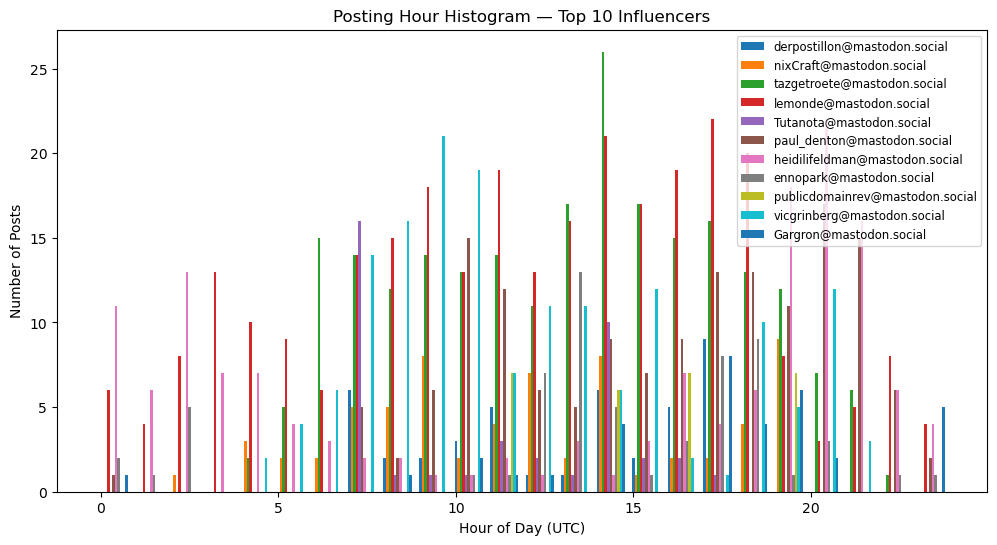

In [10]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(12, 6))
width = 0.8 / len(metrics_df)  # Adjust bar width based on the number of influencers
for i, row in enumerate(metrics_df.iterrows()):
    hours = np.array(list(range(24)))
    hist = np.array([row[1]["hour_hist"].get(h, 0) for h in hours])
    ax.bar(hours + i * width, hist, width=width, label=row[1]["handle"])
ax.set_xlabel("Hour of Day (UTC)")
ax.set_ylabel("Number of Posts")
ax.set_title("Posting Hour Histogram — Top 10 Influencers")
ax.legend(loc="upper right", fontsize="small")
plt.show()

In [11]:

print("Trending Tags (7-day window, instance-provided):")
tt = trending_tags_7d(limit=20)
display(tt)

# Optional: render a word cloud from trending tags (7-day instance trends)
counts = dict(zip(tt["hashtag"], tt["uses_7d"]))
render_wordcloud_from_counts(counts)


Trending Tags (7-day window, instance-provided):


,hashtag,uses_7d,accounts_7d
0,#worldphotographyday,239,190
1,#announcementsongsorlimericks,185,76
2,#tunetuesday,130,94
3,#songsfromthefuture,122,83
4,#sweetandsourpoetry,103,47
5,#meermittwoch,85,78
6,#上手い下手関係なく今までで1番頑張って描いた絵,77,72
7,#thicktrunktuesday,62,58
8,#texturetuesday,59,50
9,#tercinema,53,43


ModuleNotFoundError: No module named 'wordcloud'

In [ ]:
from pathlib import Path
OUTDIR = Path("./mastodon_outputs")
OUTDIR.mkdir(parents=True, exist_ok=True)

top10_df.to_csv(OUTDIR / "top10_accounts.csv", index=False)
metrics_df.to_json(OUTDIR / "metrics.json", orient="records")
tt.to_csv(OUTDIR / "trending_tags_7d.csv", index=False)

# Also save hour/dow histograms and hashtag counts per account for quick reuse
per_account = {}
for _, row in metrics_df.iterrows():
    per_account[row["handle"]] = {
        "hour_hist": row["hour_hist"],
        "dow_hist": row["dow_hist"],
        "hashtags": dict(row["top_hashtags"])
    }

with open(OUTDIR / "per_account_histograms.json", "w", encoding="utf-8") as f:
    json.dump(per_account, f, ensure_ascii=False, indent=2)

print("Saved outputs to:", OUTDIR.resolve())


Saved outputs to: /Users/pr.germux/Desktop/Python Projects/Data Science Bootcamp/herman-muzychko/03_Visualization/day4/masto_outputs



## Next Steps (for Streamlit)
- Load `top10_accounts.csv`, `metrics.json`, `trending_tags_7d.csv`, and `per_account_histograms.json` to render:
  - Tables for Top‑10 and Metrics.
  - Heatmaps for hour/day distributions.
  - Word cloud from trending tags (7d) or merged per‑account hashtags.
- Add a **“Refresh”** button that re‑runs the same logic (respect pacing); optionally cache responses by timeframe.
- Optional: add a **token** field to use a personal `MASTODON_TOKEN` for higher rate limits.
